In [1]:
%pylab inline
import uncertainties
# Daten einlesen
def read (path,offset=2, *kwargs):
    from numpy import array as array
    doc = []
    with open (path+".TKA", 'r') as myfile:
        data = myfile.read().replace(',', '.').replace('\n', ',').replace('  ', ',').replace("\t",",")
        datarray = data.split(',')
        output = []
    for item in datarray:
        if item != '':
            output.append(int(item))
    dataset = array(output[offset:])
    dataset = [array(range(len(dataset))), dataset]
    return dataset

Populating the interactive namespace from numpy and matplotlib


In [2]:
calibr = array([
    array([  # ch
        183,
        180,
        177,
        173,
        166,
        153,
        139,
        126,
        112,
        99,
        98,
        85,
        71,
        58,
        54,
        51,
        48,
        44,
        41,
        38,
        35,
        32,
        30,
        28,
        28,
        27,
        27,
        27
    ]),array([  # t
        190.5,
        186.5,
        182.5,
        178.5,
        170.5,
        154.5,
        132.5,
        122.5,
        106.5,
        90.5,
        90,
        74,
        58,
        42,
        38,
        34,
        30,
        26,
        22,
        18,
        14,
        10,
        6,
        2,
        1.5,
        1,
        0.5,
        0
    ])+3*2.5
])

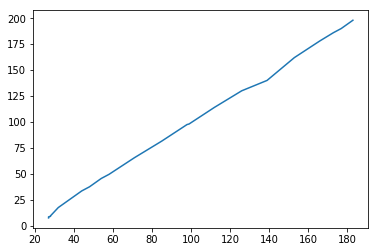

In [3]:
plt.plot(*calibr)

In [4]:
def fit_pm(x, y, func=lambda x: x, p0=None):
    """
        fit_pm takes data points and makes an exponential curve fit. It returns
        the parameters with errors and the coefficient of determination
        Parameters:
        -----------
        x: x-value of the data points.
        y: y-value of the data points.
        func: Function to be fitted to.
        Returns:
        -----------
        list: Gives back a list with the parameters of an expotential function the
              corresponding errors and the coefficient of determination.
    """
    from scipy.optimize import curve_fit
    import numpy as np
    popt, pcov = curve_fit(func, x, y, p0=p0)
    params = popt.copy()
    errors = np.sqrt(np.diag(pcov))
    r = np.array(y) - func(np.array(x), *params)
    rss = np.sum(r ** 2)
    tss = np.sum((y - np.mean(y)) ** 2)
    R_2 = 1 - (rss / tss)
    try:
        from uncertainties import unumpy as unp
        return unp.uarray(params, errors), R_2
    except:
        return np.array(params), np.array(errors), R_2

def linfit_pm(x, y, p0=None):
    return fit_pm(x, y, func=lambda x, a, b,: a * x + b, p0=p0)

def val(x):
    from uncertainties import unumpy
    try:
        return unumpy.nominal_values(x)
    except TypeError:
        return x

def err(x):
    from uncertainties import unumpy
    return unumpy.std_devs(x)

In [5]:
[slope,offset], R_2=linfit_pm(*calibr)

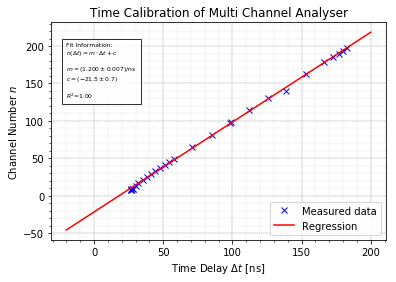

In [6]:
from uncertainties import unumpy as unp
x=np.linspace(-20,200)
y=x*slope+offset
#plt.figure(dpi=300)
plt.title('Time Calibration of Multi Channel Analyser')
plt.ylabel('Channel Number $n$')
plt.xlabel(r'Time Delay $\Delta t$ [ns]')

plt.plot(calibr[0],calibr[1],"bx",label="Measured data")
plt.plot(x,unp.nominal_values(y),"r-",label="Regression")

plt.grid(which='major',linestyle='--', color='grey',linewidth=0.4)
plt.grid(which='minor',linestyle=':', color='grey',linewidth=0.2)
plt.minorticks_on()

plt.legend(loc=4)
plt.text(-20, 130,
         'Fit Information:\n$n(\\Delta t)=m\\cdot \\Delta t +c $\n\n$m=({:.3f}\\pm {:.3f})$/ns\n$c=({:.1f}\\pm {:.1f})$\n\n$R^2$={:.2f}'
         .format(val(slope),err(slope),val(offset),err(offset),R_2), bbox={'facecolor':'white', 'alpha':0.8}, fontsize=6)
#plt.savefig("time_cal.png")
plt.show()

# Auswertung der Hauptmessung

In [7]:
data_raw = read("Hauptmessung")
data = [data_raw[0],[]]
#fehler: sqrt(n)
for i in range(len(data_raw[1])):
    data[1].append(uncertainties.ufloat(data_raw[1][i],np.sqrt(data_raw[1][i])))
len(data[1])
data[0]=(data[0]-offset)/slope

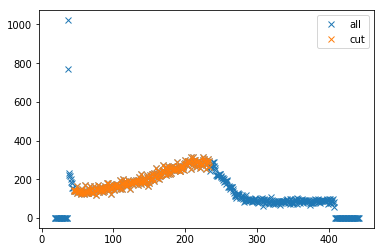

In [8]:
start,stop = 32,260
x = data[0][start:stop]
y = data[1][start:stop]
plt.plot(val(data[0]),val(data[1]),"x",label="all")
plt.plot(val(x),val(y),"x",label="cut")
plt.legend()
plt.show()

In [9]:
def expfit_pm(x, y, p0=None):
    import numpy as np
    return fit_pm(x, y, func=lambda x, a, b, c, d: a * np.exp(b * (x+d)) + c, p0=p0)

def eexp(x,a,b,c,d):
    return a * np.exp(b * (x+d)) + c

In [10]:
vals,x_2=expfit_pm(val(x),val(y),p0=[30,0.1,1,1])
print(vals)

[150.2566395091662+/-201910.55508585568
 0.003750203726262265+/-0.0008370716096695589
 -53.31695387154265+/-57.577347880967174
 0.34090097283385834+/-358730.73294273944]


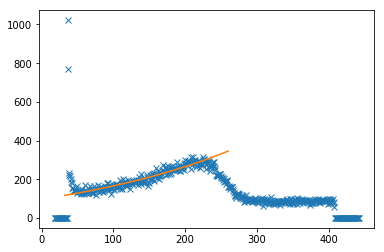

T_1/2 (1.8+/-0.4)e+02


In [11]:
xx = np.linspace(start,stop)
plt.plot(val(data[0]),val(data[1]),"x")
plt.plot(xx,eexp(xx,*val(vals)))
plt.show()
print("T_1/2",np.log(2)/vals[1])

# Background

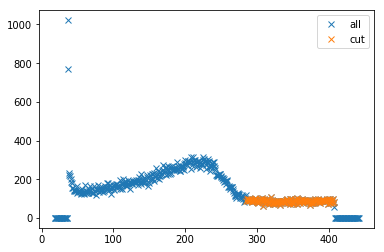

In [12]:
start2,stop2 = 321,468
x = data[0][start2:stop2]
y = data[1][start2:stop2]
plt.plot(*val(data),"x",label="all")
plt.plot(val(x),val(y),"x",label="cut")
plt.legend()
plt.show()

In [13]:
[slope2,offset2],R_2_2 = linfit_pm(val(x),val(y))
offset3 = uncertainties.ufloat(val(mean(y)),err(mean(y)))
print("mean")
print(offset3)
print("fit")
print(slope2)
print(offset2)
print(R_2_2)
offset2=offset3

mean
87.0+/-0.8
fit
-0.015+/-0.020
92+/-7
0.0040652823860812815


# Fit w\o background

In [14]:
def fit_pm(x, y, func=lambda x: x, p0=None):
    from scipy.optimize import curve_fit
    import numpy as np
    popt, pcov = curve_fit(func, x, y, p0=p0, bounds=(0,100))
    params = popt.copy()
    errors = np.sqrt(np.diag(pcov))
    r = np.array(y) - func(np.array(x), *params)
    rss = np.sum(r ** 2)
    tss = np.sum((y - np.mean(y)) ** 2)
    R_2 = 1 - (rss / tss)
    try:
        from uncertainties import unumpy as unp
        return unp.uarray(params, errors), R_2
    except:
        return np.array(params), np.array(errors), R_2

In [15]:
#start,stop = 40,230


cleaned = [data[0],data[1]-(data[0]*slope2+offset2)]

x = cleaned[0][start:stop]
y = cleaned[1][start:stop]
vals2,x_2=expfit_pm(val(x),val(y),p0=[0,0.1,0,0])
print(vals2)
print("T_1/2",np.log(2)/vals2[1])

[31.95628168092037+/-3767004.759280298
 0.008006984748995232+/-0.0009470181278591201
 1.5237531649020533e-10+/-14.125085696745463
 15.578670083651076+/-14722140.130879778]
T_1/2 87+/-10


In [16]:
#start-=ö
#stop-=ü

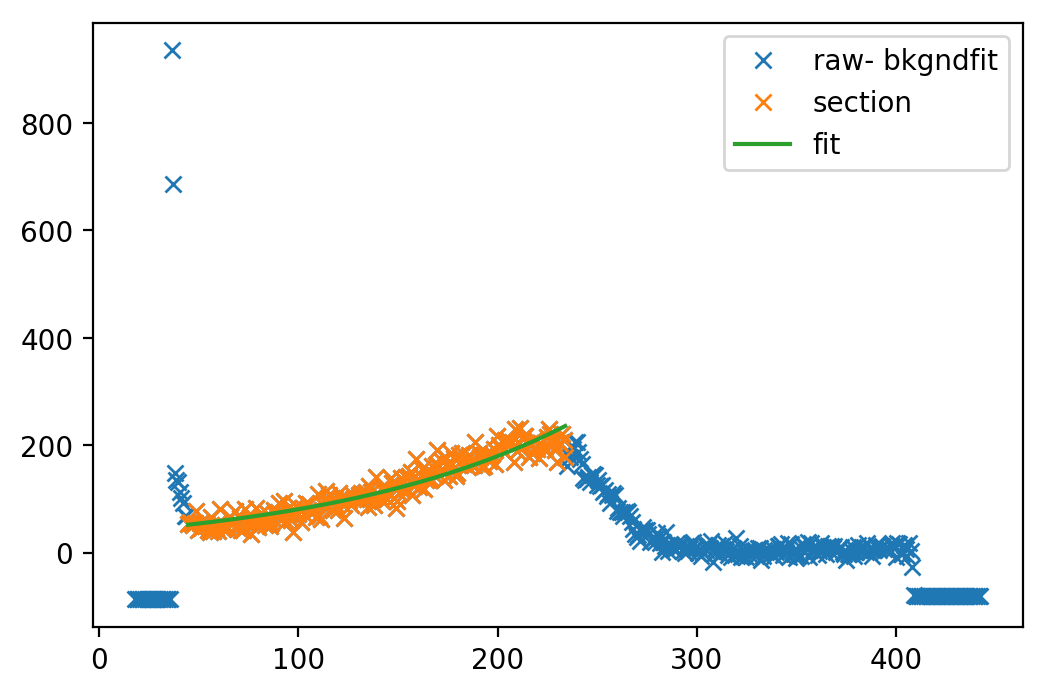

In [17]:
kek = 30
eke = -41
plt.figure(dpi=200)
plt.plot(val(cleaned[0]), val(cleaned[1]),"x",label="raw- bkgndfit")
plt.plot(val(x),val(y),"x",label="section")
plt.plot(val(cleaned[0][start:stop]),eexp(val(cleaned[0][start:stop]),*val(vals2)),label="fit")
plt.legend()
axes=plt.gca()
#axes.set_xlim([150,300])

plt.show()

# Log-BS

In [28]:
def val(x):
    from uncertainties import unumpy
    try:
        return unumpy.nominal_values(x)
    except TypeError:
        try:
            return x[0]
        except TypeError:
            return "not working"

log=[]
log.append(data[0])
log.append([])
for item in data[1]:
    try:
        log[1].append(unp.log(item))
    except ValueError:
        log[1].append(item)

In [30]:
for i in range(len(log[1])):
    if log[1][i] == log[1][1]:
        print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
500
501
502
503
504
505
506
507
508
509


In [46]:
len(newlog[0])

447

In [77]:
# first zeros 0,21
# last zeros 470,509
newlog = [log[0][22:469],log[1][22:469]]
startlog,stoplog=start-21,stop-21
start2log,stop2log=start2-21,stop2-21
x = val(newlog[0])
y = []
y_err=[]
for item in newlog[1]:
    y.append(float(val(item)))
    y_err.append(float(err(item)))

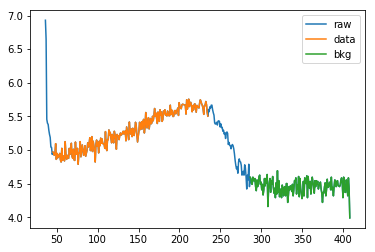

In [76]:
plt.plot(x,y,label="raw")
plt.plot(x[startlog:stoplog],y[startlog:stoplog],label="data")
plt.plot(x[start2log:stop2log],y[start2log:stop2log],label="bkg")
plt.legend()
plt.show()

In [79]:
fit2x,fit2y=x[start2log:stop2log],y[start2log:stop2log]
[slope2log,offset2log],R_2_2log = linfit_pm(fit2x,fit2y)
print(slope2log)
print(offset2log)

0.00000+/-0.00025
4.46+/-0.09


In [81]:
cleanedlog=[x,y-(x*slope2log+offset2log),y_err]

In [84]:
fitx,fity=cleanedlog[0][startlog:stoplog],val(cleanedlog[1][startlog:stoplog])
[slopelog,offsetlog],R_2_log = linfit_pm(fitx,fity)
print(slopelog)
print(offsetlog)

0.00473+/-0.00010
0.172+/-0.015


In [ ]:
%pylab inline
import uncertainties
# Daten einlesen
def read (path,offset=2, *kwargs):
    from numpy import array as array
    doc = []
    with open (path+".TKA", 'r') as myfile:
        data = myfile.read().replace(',', '.').replace('\n', ',').replace('  ', ',').replace("\t",",")
        datarray = data.split(',')
        output = []
    for item in datarray:
        if item != '':
            output.append(int(item))
    dataset = array(output[offset:])
    dataset = [array(range(len(dataset))), dataset]
    return dataset


def val(x):
    from uncertainties import unumpy
    try:
        return unumpy.nominal_values(x)
    except TypeError:
        return x


def err(x):
    from uncertainties import unumpy
    return unumpy.std_devs(x)

In [ ]:
from uncertainties import unumpy as np
log_raw = read("Hauptmessung")
log_data = [log_raw[0],[]]
#fehler: sqrt(n)
for i in range(len(log_raw[1])):
    try:
        log_data[1].append(unp.log(uncertainties.ufloat(log_raw[1][i],np.sqrt(log_raw[1][i]))))
    except ValueError:
        log_data[1].append((uncertainties.ufloat(log_raw[1][i],np.sqrt(log_raw[1][i]))))
#len(log_data[1])
#intern = []
#for i in range(len(log_data[1])):
#    if log_data[1][i] > 0:
#        intern.append(unp.log(log_data[1][i]))
#    else:
#        intern.append(log_data[1][i])
#log_data.append(intern)

In [ ]:
x = log_data[0]
y = []
y_err=[]
for item in log_data[1]:
    y.append(val(item))
    y_err.append(err(item))
#y = val(log_data[1])
plt.figure(dpi=150)
plt.errorbar(x,y,y_err,fmt=":",label="raw")
plt.plot(x[start:stop],y[start:stop],label="cut")
plt.plot(x[start2:stop2],y[start2:stop2],label="backgr")

plt.show()

[slope2_log,offset2_log],R_2_2_log = linfit_pm(log_data[0][start2:stop2],y[start2:stop2],[0,5])
print(slope2_log,offset2_log)
buffer = []
